In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
%matplotlib inline

In [2]:
def Fake_Spike_Activation_function(r):
    rstate=np.zeros(len(r))
    edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
    for i in range(4):
        for j in np.where(r>=edges[i])[0]:
            rstate[j] = np.random.poisson(i*10)
    return rstate

In [3]:
Tot=5000
dt=0.01
T=np.arange(dt,Tot,dt)
# OU ; input
tau= 1
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering for OUSmoothed
cutoffFreq = 1
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)

LPOU = ((LPOU-min(LPOU))/(max(LPOU)-min(LPOU))-0.5)*0.1

In [4]:
alpha = 80.
beta = 2.
k = 100.
g = 10.
phi = 1.

k*g*phi/alpha/beta,  beta*k/(alpha*beta+k*g*phi)

(6.25, 0.1724137931034483)

In [5]:
starters = 3000
bright_time = 3000
rest_time = 1000
nstep = rest_time+bright_time+starters
x1 = np.hstack((np.zeros(starters),1*np.ones(bright_time),np.zeros(rest_time)))

LPOU = ((LPOU[:bright_time]-min(LPOU[:bright_time]))/(max(LPOU[:bright_time])-min(LPOU[:bright_time]))-0.5)*0.9+1
x2 = np.hstack((np.zeros(starters),LPOU,np.zeros(rest_time)))
# noise = (np.random.randn(bright_time))*0.05+1
# x2 = np.hstack((np.zeros(starters),noise,np.zeros(rest_time)))

y1 = np.zeros(nstep)
y2 = np.zeros(nstep)
z1 = np.zeros(nstep)
z2 = np.zeros(nstep)

for i in range(nstep-1):
    dyj1 =(-alpha*y1[i]+k*(x1[i]-z1[i]))*dt
    y1[i+1] = (y1[i]+dyj1)
    dzj1 =(-beta*z1[i]+g*y1[i])*dt
    z1[i+1] = (z1[i]+dzj1)
    
    dyj2 =(-alpha*y2[i]+k*(x2[i]-z2[i]))*dt
    y2[i+1] = (y2[i]+dyj2)
    dzj2 =(-beta*z2[i]+g*y2[i])*dt
    z2[i+1] = (z2[i]+dzj2)

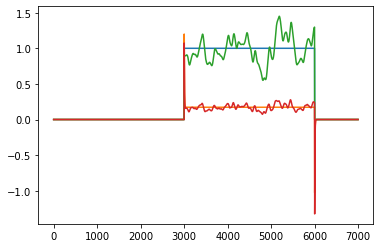

In [6]:
plt.plot(x1)
plt.plot(y1)

plt.plot(x2)
plt.plot(y2)

In [7]:
trial = 500
spike1 = np.zeros((trial, len(y1)))
spike2 = np.zeros((trial, len(y2)))
for i in range(trial):
    spike1[i,:] = Fake_Spike_Activation_function( y1)
    spike2[i,:] = Fake_Spike_Activation_function( y2)

30251.89 ± 167.68476943360122


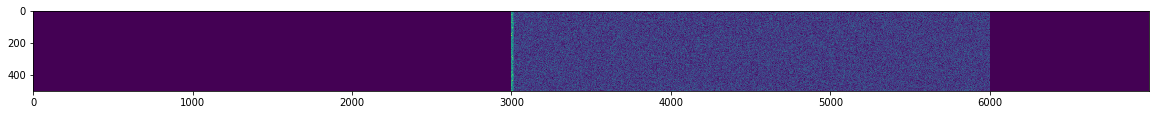

In [8]:
plt.imshow(spike1)
plt.gcf().set_size_inches(20, 20)
print(np.mean(np.sum(spike1, axis=1)), u"\u00B1",np.std(np.sum(spike1, axis=1)))

13801.178 ± 117.91837141005637


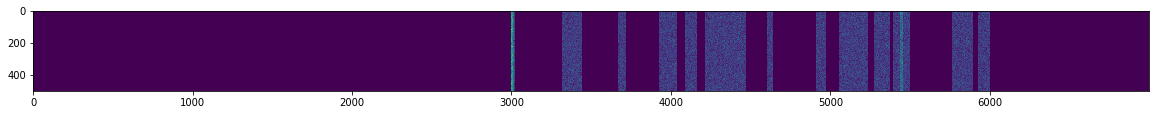

In [9]:
plt.imshow(spike2)
plt.gcf().set_size_inches(20, 20)
print(np.mean(np.sum(spike2, axis=1)), u"\u00B1",np.std(np.sum(spike2, axis=1)))